<a href="https://colab.research.google.com/github/Monaa48/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/main/notebooks/ch09_unsupervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 09 — Unsupervised Learning Techniques

## 1) Summary
This chapter focuses on **unsupervised learning**, where labels are not available (or not used) during training.
Main topics:
- **Clustering** (K-Means, DBSCAN) and how to evaluate clustering quality.
- **Gaussian Mixture Models (GMM)** for soft clustering and density estimation.
- **Anomaly detection** as a practical application of density/cluster structure.
- **Association rule mining** is sometimes mentioned in broader unsupervised contexts, but here we focus on the book’s main implementations.

Key outcomes from this chapter:
- You can group similar instances without labels.
- You can discover structure (clusters, density regions) and use it for downstream tasks.
- You learn that evaluation is tricky: internal metrics (silhouette) vs external metrics (ARI/NMI when labels exist for benchmarking).
- You learn that different algorithms assume different cluster shapes (spherical for K-Means, arbitrary for DBSCAN, elliptical for GMM).

## 2) Learning Goals
- Understand K-Means objective (inertia) and practical workflow (fit → predict → transform).
- Choose k using inertia curve (elbow) and silhouette score.
- Understand limitations of K-Means (spherical clusters, sensitivity to scale/outliers/initialization).
- Use DBSCAN for arbitrary-shaped clusters and noise detection.
- Use Gaussian Mixtures for soft clustering (probabilities) and density estimation.
- Apply an unsupervised model for anomaly detection on a synthetic dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

In [2]:
def plot_clusters(X, labels, title=None):
    plt.figure(figsize=(6, 5))
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=10)
    plt.xlabel("x1")
    plt.ylabel("x2")
    if title:
        plt.title(title)
    plt.show()

## 3) Clustering Dataset (make_blobs)

We start with a simple dataset where clusters are roughly spherical.
This matches K-Means assumptions reasonably well.

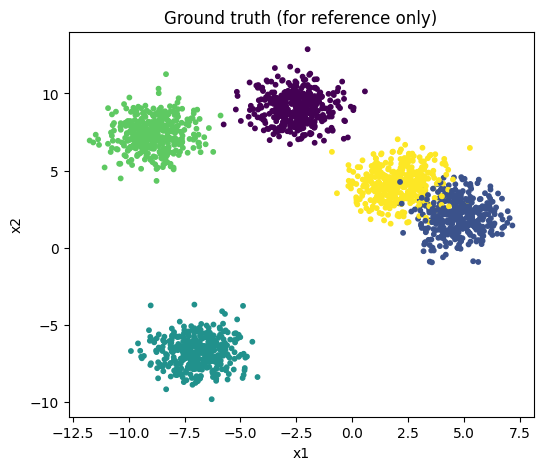

(2000, 2)

In [3]:
X, y_true = make_blobs(n_samples=2000, centers=5, cluster_std=1.0, random_state=42)
plot_clusters(X, y_true, title="Ground truth (for reference only)")
X.shape

# Part A — K-Means

## 4) K-Means: fit, predict, cluster centers

### Theory notes
K-Means tries to minimize **inertia** (within-cluster sum of squared distances):
\sum_{i=1}^m ||x_i - μ_{c(i)}||^2

Algorithm (high-level):
1. Initialize k centers (random or k-means++).
2. Assign each point to the closest center.
3. Recompute centers as the mean of assigned points.
4. Repeat until convergence.

Important practical notes:
- Scaling matters (distance-based).
- Initialization matters; use `n_init` and k-means++.

In [4]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
kmeans.fit(X)

labels = kmeans.labels_
centers = kmeans.cluster_centers_

labels[:10], centers

(array([4, 1, 4, 1, 4, 3, 1, 0, 4, 3], dtype=int32),
 array([[-6.92958209, -6.79739545],
        [-2.52846663,  9.01204984],
        [ 2.03822483,  4.16889545],
        [-8.85754411,  7.33176566],
        [ 4.75665206,  2.01872582]]))

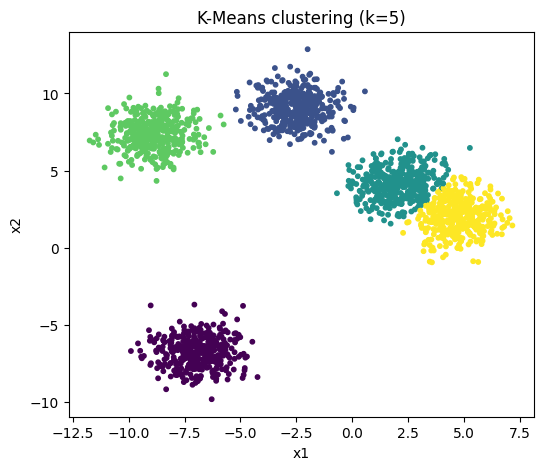

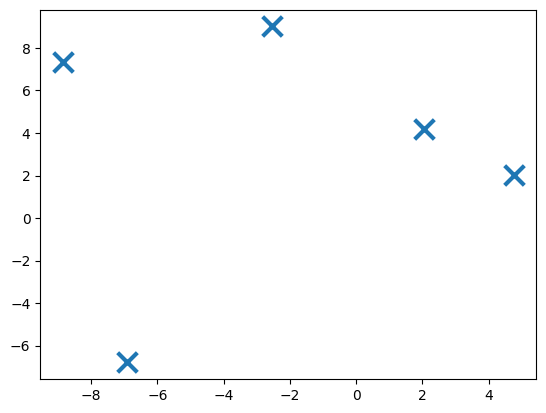

In [5]:
plot_clusters(X, labels, title="K-Means clustering (k=5)")
plt.scatter(centers[:, 0], centers[:, 1], marker="x", s=200, linewidths=3)
plt.show()

## 5) Choosing k: inertia curve (elbow) and silhouette

### Inertia (elbow)
- Inertia always decreases as k increases.
- We look for a “knee” where gains diminish.

### Silhouette score
Silhouette combines cohesion and separation (range -1 to 1).
- Higher is better.
- Useful when cluster labels are not available.

In [6]:
inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X, km.labels_))

inertias, silhouettes[:3], silhouettes[-1]

([58361.91600047743,
  14841.318954081418,
  6256.404776086768,
  3856.824513686166,
  3633.5622760475444,
  3316.019837196315,
  3047.4602634185744,
  2782.0574139808946,
  2621.3924623619337],
 [np.float64(0.5901049571013153),
  np.float64(0.7032999865558672),
  np.float64(0.7287274663971529)],
 np.float64(0.3536692275798898))

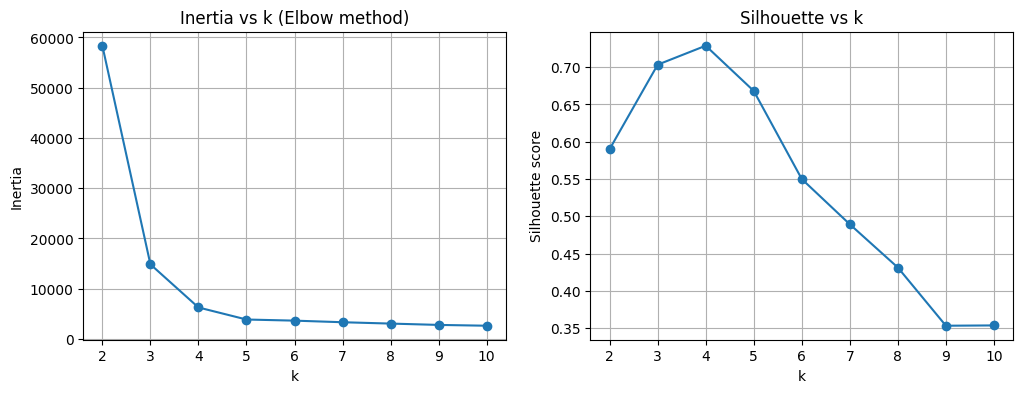

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(list(K_range), inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Inertia vs k (Elbow method)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(list(K_range), silhouettes, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette vs k")
plt.grid(True)

plt.show()

## 6) K-Means for feature engineering (transform)

`kmeans.transform(X)` returns distances to each cluster center.
These distances can be used as new features for another supervised model later.

In [8]:
X_kmeans_features = kmeans.transform(X)
X_kmeans_features.shape, X_kmeans_features[:2]

((2000, 5),
 array([[14.12920256,  8.58816965,  1.93284413, 13.08230688,  1.55644912],
        [16.83578387,  0.43270639,  6.81867258,  6.84151103, 10.2363717 ]]))

# Part B — DBSCAN (Density-based clustering)

## 7) DBSCAN: arbitrary-shaped clusters + noise detection

### Theory notes
DBSCAN defines clusters as dense regions:
- `eps`: neighborhood radius
- `min_samples`: minimum points to form a dense region

Outputs:
- Cluster labels (0..K-1)
- Noise points labeled as -1

Strengths:
- Finds arbitrary shapes
- Detects outliers/noise
Weaknesses:
- Sensitive to `eps`
- Struggles with varying densities

In [9]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Use make_moons to highlight non-spherical structure
X_moons, y_moons_true = make_moons(n_samples=2000, noise=0.08, random_state=42)

X_moons_scaled = StandardScaler().fit_transform(X_moons)

dbscan = DBSCAN(eps=0.3, min_samples=5)
db_labels = dbscan.fit_predict(X_moons_scaled)

# Count clusters (excluding noise)
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise = np.sum(db_labels == -1)

n_clusters, n_noise

(1, np.int64(0))

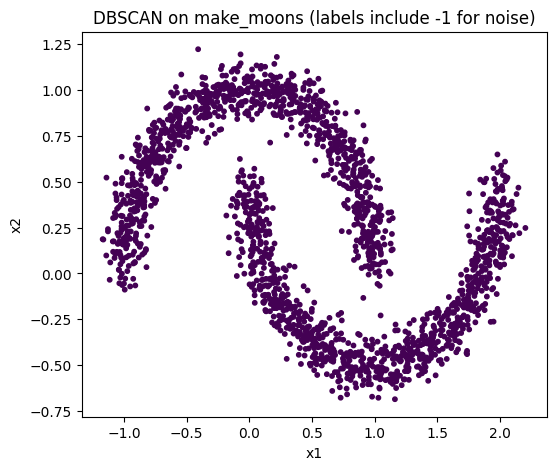

In [10]:
plot_clusters(X_moons, db_labels, title="DBSCAN on make_moons (labels include -1 for noise)")

**Interpretation guide:**
- If too many points are labeled -1 (noise), `eps` might be too small or `min_samples` too large.
- If everything becomes one cluster, `eps` might be too large.

# Part C — Gaussian Mixture Models (GMM)

## 8) GMM: soft clustering + density estimation

### Theory notes
A Gaussian Mixture Model assumes data is generated by a mixture of Gaussians:
p(x) = Σ_{k=1..K} π_k * N(x | μ_k, Σ_k)

Key differences vs K-Means:
- GMM gives **probabilities** (soft assignment) instead of hard labels.
- Clusters can be **elliptical** (via covariance).
- It can estimate density and be used for anomaly detection.

We fit a GMM on blob data and inspect predicted probabilities.

In [11]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=5, covariance_type="full", random_state=42)
gmm.fit(X)

gmm_labels = gmm.predict(X)
probas = gmm.predict_proba(X)

gmm_labels[:10], probas[:2], probas.shape

(array([4, 1, 4, 1, 4, 3, 1, 0, 4, 3]),
 array([[5.63090723e-46, 3.16303834e-16, 3.09871120e-01, 2.61861859e-40,
         6.90128880e-01],
        [2.82381755e-69, 1.00000000e+00, 1.11517085e-11, 6.79602302e-11,
         9.39382046e-24]]),
 (2000, 5))

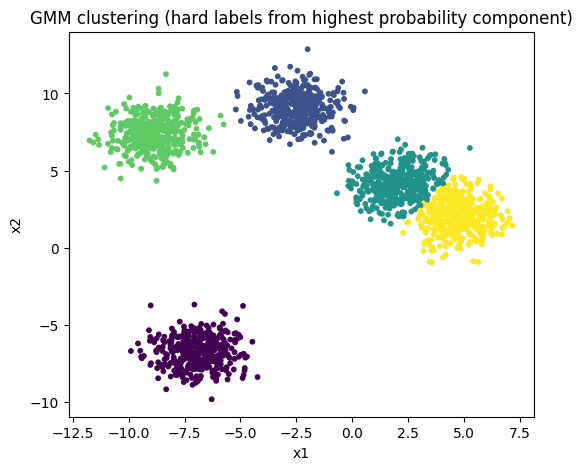

In [12]:
plot_clusters(X, gmm_labels, title="GMM clustering (hard labels from highest probability component)")

## 9) Selecting number of components with AIC/BIC

GMM provides model selection criteria:
- **AIC** and **BIC** penalize model complexity.
- Lower is better.

We evaluate a range of K and pick the K with minimal BIC/AIC.

In [13]:
aics, bics = [], []
K_range = range(1, 11)

for k in K_range:
    gmm_k = GaussianMixture(n_components=k, covariance_type="full", random_state=42)
    gmm_k.fit(X)
    aics.append(gmm_k.aic(X))
    bics.append(gmm_k.bic(X))

min_bic_k = list(K_range)[int(np.argmin(bics))]
min_aic_k = list(K_range)[int(np.argmin(aics))]

min_bic_k, min_aic_k

(5, 5)

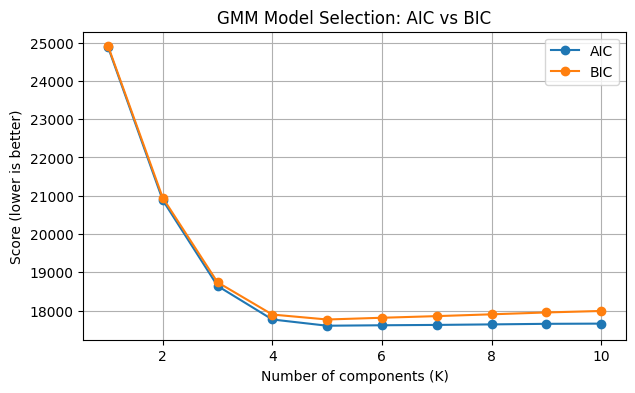

In [14]:
plt.figure(figsize=(7, 4))
plt.plot(list(K_range), aics, marker="o", label="AIC")
plt.plot(list(K_range), bics, marker="o", label="BIC")
plt.xlabel("Number of components (K)")
plt.ylabel("Score (lower is better)")
plt.title("GMM Model Selection: AIC vs BIC")
plt.legend()
plt.grid(True)
plt.show()

# Part D — Anomaly Detection (density-based using GMM)

## 10) Idea
If a model can estimate density p(x), then points with extremely low density can be treated as anomalies.

Workflow:
1. Fit a density model (here: GMM).
2. Compute log-likelihood score `score_samples(X)`.
3. Mark the lowest-scoring points as anomalies.

We use a synthetic dataset with injected outliers for demonstration.

In [15]:
# Create inliers + outliers
rng = np.random.RandomState(42)
X_inliers, _ = make_blobs(n_samples=1500, centers=1, cluster_std=1.0, random_state=42)
X_outliers = rng.uniform(low=-8, high=8, size=(50, 2))
X_ad = np.vstack([X_inliers, X_outliers])

gmm_ad = GaussianMixture(n_components=1, covariance_type="full", random_state=42)
gmm_ad.fit(X_inliers)

log_probs = gmm_ad.score_samples(X_ad)  # log p(x)
threshold = np.percentile(log_probs, 3)  # mark ~3% lowest as anomalies
anomaly_flags = (log_probs < threshold)

np.sum(anomaly_flags), threshold

(np.int64(47), np.float64(-13.545452673405036))

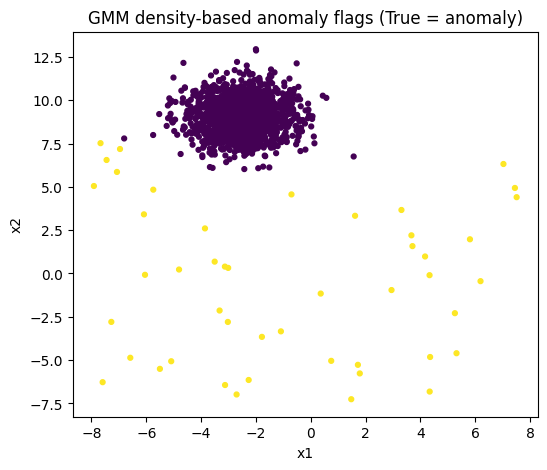

In [16]:
plt.figure(figsize=(6, 5))
plt.scatter(X_ad[:, 0], X_ad[:, 1], c=anomaly_flags, s=12)
plt.title("GMM density-based anomaly flags (True = anomaly)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

## 11) Takeaways
- Unsupervised learning is about discovering structure without labels.
- **K-Means**: fast and scalable, best for roughly spherical clusters; choose k using inertia (elbow) and silhouette.
- **DBSCAN**: finds arbitrary shapes and identifies noise, but sensitive to `eps` and struggles with varying density.
- **GMM**: soft clustering and density estimation; supports elliptical clusters; choose K with AIC/BIC.
- Density scores enable simple **anomaly detection** by thresholding low-probability points.

## 12) References
- Aurélien Géron, *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*, Chapter 9.
- scikit-learn documentation: `KMeans`, `DBSCAN`, `GaussianMixture`, `silhouette_score`.